In [55]:
import os
import sys
sys.path.append(r'C:\Users\dpoppema\OneDrive - Delft University of Technology\Documents\GitHub\HybridDune\Ruben\Pressure_sensors\S1\RBR_05')
import pandas as pd
import numpy as np
import puv
from scipy.ndimage import uniform_filter1d
import matplotlib.pyplot as plt
from datetime import datetime
import xarray as xr


In [56]:
def movmean(x, N):
    # calculate moving mean. NB: this divides values at the edges by the window length, instead of the available number of values
    y = uniform_filter1d(x, size=N, mode='constant') # for even window: backward avg. So window 2: x_m(i)=[x(i-1)+x(i)]/2. x_m(i=1) = x(i=1)/2

    # compensate edges for number of values, i.e. the truncated window length
    S1 = np.arange(np.ceil(N/2), N)
    S2 = np.ones(len(x)-N+1)*N
    S3 = np.arange(N-1, np.floor(N/2), -1)
    S = np.concatenate((S1, S2, S3)) 
    return y * N / S
    # for 2D inspiration, see https://stackoverflow.com/questions/23000260/numpy-two-dimensional-moving-average

In [57]:
# LOAD AND CROP THE DATA
n_file = 4 # select file
map_file_in_all  = [r"O:\HybridDune experiment\data ADV, OBS\raw NetCDF\ADV S1ADV1 raw data - period 1 20mins.nc",
                    r"O:\HybridDune experiment\data ADV, OBS\raw NetCDF\ADV S2ADV1 raw data - period 1 20mins.nc",
                    r"O:\HybridDune experiment\data ADV, OBS\raw NetCDF\ADV S3ADV1 raw data - period 1 20mins.nc",
                    r"O:\HybridDune experiment\data ADV, OBS\raw NetCDF\ADV S4ADV1 raw data - period 1 20mins.nc",
                    r"O:\HybridDune experiment\data ADV, OBS\raw NetCDF\ADV S3ADV2 raw data - period 1 20mins.nc"]

map_file_out_all = [r"O:\HybridDune experiment\data ADV, OBS\QC\ADV S1ADV1 QC - period 1, 20mins.nc",
                    r"O:\HybridDune experiment\data ADV, OBS\QC\ADV S2ADV1 QC - period 1, 20mins.nc",
                    r"O:\HybridDune experiment\data ADV, OBS\QC\ADV S3ADV1 QC - period 1, 20mins.nc",
                    r"O:\HybridDune experiment\data ADV, OBS\QC\ADV S4ADV1 QC - period 1, 20mins.nc",
                    r"O:\HybridDune experiment\data ADV, OBS\QC\ADV S3ADV2 QC - period 1, 20mins.nc"]

block_length = 20 #minutes. NB: BLOCK LENGTH CAN ONLY BE 20 OR 60 MINUTES, SPLITTIING IN BLOCKS IS HARDCODED, GIVEN 10s GAP BETWEEN BURSTS

map_file_in = map_file_in_all[n_file]
map_file_out = map_file_out_all[n_file]
ds = xr.open_dataset(map_file_in)

# crop dataset: only keep data when sensor is installed at location at the beach (remove times when running indoors/...)
t0 = pd.to_datetime(ds.t_installed.values)
t1 = pd.to_datetime(ds.t_removed.values) - pd.DateOffset(minutes=block_length) # - block_length, because t1 indicates the START of the last block. 
ds = ds.sel(t=slice(t0, t1))

# ADD GENERAL SETTINGS 
rho = 1027 # density of water [kg/m3]
g = 9.8125 # gravitational acceleration [m/s2]

ds['rho'] = rho
ds['rho'].attrs = {'units': 'kg/m3', 'long_name': 'water density'}

ds['g'] = g
ds['g'].attrs = {'units': 'm', 'long_name': 'gravitational acceleration'}

In [58]:
# QUALITY CONTROL: CORRELATION, VELOCITY LIMITS, VELOCITY CHANGE, PRESSURE CHANGE
# parameters for the quality control:
QC = {
     'uLim':2.1, #maximum acceptable recorded u-velocity # Daan: check
     'vLim':2.1, #maximum acceptable recorded v-velocity
     'wLim':0.6, #maximum acceptable recorded w-velocity
     'corTreshold':53} #minimum correlation
#     'maxFracNans': 0.50, #maximum fraction of rejected pings in the sample to proceed with processing based on interpolation                  NB: Not used automatically, removed from QC
#     'maxGap' : 4 } #maximum amount of sequential rejected pings in the sample to proceed with processing based on interpolation, in seconds     idem

# if correlation is outside confidence range
mc1 = ds.cor1 > QC['corTreshold'] # true if valid data
mc2 = ds.cor2 > QC['corTreshold']
mc3 = ds.cor3 > QC['corTreshold']

# if observation is outside of velocity range
mu1 = np.abs(ds.u) < QC['uLim']
mu2 = np.abs(ds.v) < QC['uLim']
mu3 = np.abs(ds.w) < QC['uLim']

# if du larger than 4*std(u) then we consider it outlier and hence remove:
md1 = np.abs(ds.u.diff('N')) < 3 * ds.u.std(dim='N')
md1 = md1.combine_first(mu1)
md2 = np.abs(ds.v.diff('N')) < 3 * ds.v.std(dim='N')
md2 = md1.combine_first(mu2)
md3 = np.abs(ds.w.diff('N')) < 3 * ds.w.std(dim='N')
md3 = md1.combine_first(mu3)

ds['mc'] = np.logical_and(np.logical_and(mc1, mc2), mc3) # True if valid data
ds['mu'] = np.logical_and(np.logical_and(mu1, mu2), mu3)
ds['md'] = np.logical_and(np.logical_and(md1, md2), md3)
ds['mc'].attrs = {'units': '-', 'long_name': 'mask correlation'}
ds['mu'].attrs = {'units': '-', 'long_name': 'mask vel limit'}
ds['md'].attrs = {'units': '-', 'long_name': 'mask deviation'}

mp = np.abs(ds.p.diff('N')) < 4 * ds.p.std(dim='N')    # mask for pressure, if pressure difference is larger than 4*std(p) then we consider it outlier and remove it
mp = xr.concat([mp.isel(N=0), mp], dim="N")            # add first value to the mask, because mask length is one shorter than the data length (because of the diff)

ds.coords['maskp'] = (('t', 'N'), mp.values)           # true if valid data
ds.coords['maskv'] = (('t', 'N'), np.logical_and(np.logical_and(ds.mc.values, ds.mu.values), ds.md.values))

In [59]:
# # ATMOSPHERIC PRESSURE CORRECTION 
# Set smoothing window for atmpospheric pressure
T_smooth_air = 10 # [s]     # measured with 8 hz. But p_water and p_air are measured up to 100m apart (and p_air inside). Affected different by wind gusts, so filter out short-term variation

# Open raw data file  of reference sensor 
dataFile =r'O:\HybridDune experiment\data RBR, OSSI\copy RBR Udrive series1\raw NetCDF\Pressure sensor refP1 RBR4 raw data - period 1.nc'
ds0 = xr.open_dataset(dataFile)

# Determine moving average. 
ds0.p.values = movmean(ds0.p.values, 8*T_smooth_air) # smooth over 8hz * n seconds

# Add instrument calibration
ds0.p.values = ds0.p.values + -543 # for pressure in Pa. Coefficient for instrument ref.P1 RBR4

# -------------------------------------------------------------------------------------------
# Cast reference (air) pressure in same 2D array as ADV data

# Step 1: reshape to hourly blocks ---------------------------------------
# reshape to one column per burst in data array
pt = ds0.p.values 
nSamples = len(pt)
dt = ds0.isel(t=1).t - ds0.isel(t=0).t

burstDuration = pd.Timedelta('3600s')  # Burst duration (in minutes, x 60) NB: DAAN: CHANGE WHEN BLOCK LENGTH CHANGES!
burstLength = int(burstDuration / dt)
nBursts = int(np.floor(nSamples / burstLength))

pt = pt[:nBursts * burstLength]
t_full = ds0.t.values[:nBursts * burstLength]  # time vector for all samples, up to the last complete burst. skip incomplete burst at end
t_block = t_full[::burstLength]  # take every nth step, so t = t0 of every burst

N = (ds0.t.values[:burstLength] - ds0.t.values[0]) / np.timedelta64(1, 's')  # time in seconds since start of burst

# Cast pressure into a 2D array 
ds_2D = xr.Dataset(data_vars={},    # Temporary 2D dataset, with cooridnates t (no. of blocks), N (obs within block)
                coords={'t': t_block,
                        'N': N})
ds_2D['p'] = (('t', 'N'), pt.reshape((nBursts, burstLength)))      # relative pressure, pAir subtracted

# Step 2: reshape to ±20min blocks, taking into account the 10s gap between bursts --------------------------
if block_length == 20:
        ds_2D = ds_2D.isel(N=slice(0, -81)) # for every block, skip the last 10sx8 hz, plus 1 observation to make N divisible by 3

        # make a variable t_new
        t0 = ds_2D['t'].values[0]  
        N_t_new = 3 * ds_2D.sizes['t'] # new number of blocks
        N_N_new = 9573              # new number timesteps in block. (28720/3=9573.333, 1 timestep thrown away)

        # make t_new: start at t0, with steps of [9573, 9573, 9654]/8 seconds (±20min, with 10s gap between bursts), and length of N_t_new
        pattern = [9573, 9573, 9654]
        repeats = N_t_new // len(pattern)
        deltas = pattern * repeats 
        t_new = np.array([t0 + np.timedelta64(int(sum(deltas[:i])*1000/8), 'ms') for i in range(N_t_new)]) # *1000/8 to convert to ms, given 8hz
        N_new = ds_2D.N.values[0:N_N_new]

        # make a new dataset ds_new, with the new time dimension and the new N dimension
        ds_2D = xr.Dataset( {  'p': (('t', 'N'), ds_2D.p.values.reshape((N_t_new, N_N_new))) },
                                coords = { 't': t_new, 'N': N_new } )

# Calculate relative pressure (i.e. subtract atmospheric pressure) --------------------------
ds['pc'] = ds['p'] - ds_2D['p']  # NB: XArray finds the corresponding time steps automatically, no need to crop to the same time range

# Metadata
ds['pc'].attrs = {'units': 'Pa', 'long_name': 'pressure', 'comments': 'Relative pressure, so corrected for air pressure'}

In [60]:
# CALCULATE WATER HEAD ABOVE PRESSURE SENSOR; MEAN SURFACE ELEVATION
# interpolate zb to zb_block for every t -----------------------------------
t = pd.to_datetime(ds.t.values)
t_zb = pd.to_datetime(ds.t_zb.values)                   # Convert to pandas datetime for consistency

t_2D = ds.t.values[:, None] + ds.N.values[None, :] * np.timedelta64(1, 's') # make t_2D a 2D array, for every t, N (equal to t plus N in seconds)
t_2D = pd.to_datetime(t_2D)                             # Convert to pandas datetime for consistency


zb_block = np.interp(t, t_zb, ds.zb)                    # Interpolate bed level to block time vector
#zb_block2 = np.reshape(zb_block,(len(zb_block),1))              # reshape from row to column vector for compatibility with p

# interpolate zb to zb_2D for every t, N -----------------------------------
# zb_2D = np.interp(t_2D, t_zb, ds.zb)                    # Interpolate bed level to block time vector

# resample zi_p to zi_p_2D for every t,N, so that the water height above the pressure sensor can be calculated -----------------------------------
# use previous known value (so step-wise, not linear interpolation)
t_zi = pd.to_datetime(ds.t_zi.values)
zi_p = ds.zi_p.values

idx = np.searchsorted(t_zi, t_2D, side='right') - 1
idx = np.clip(idx, 0, len(zi_p) - 1)                            # Ensure indices are within bounds
zi_p_2D = zi_p[idx]

# Calculate water level, water depth
ds['eta'] = ds['pc'] / rho / g + zi_p_2D
ds['eta'].attrs = {'units': 'm+NAP', 'long_name': 'hydrostatic water level'} # every timestep (every, t, N)

# QUALITY CONTROL 2: CHECK VALIDITY PRESSURE DATA, THEN CALCULATE BLOCK AVERAGES
# remove pressure observations where the estimated water level is lower than the pressure sensor height with margin of error of 10 cm
ds.coords['maskd'] = (('t', 'N'), zi_p_2D < (ds['eta'].values - 0.1)) # true if valid data
ds[['p','pc','eta']] = ds[['p','pc','eta']].where(ds.maskd == True)

ds['zsmean'] = ds.eta.mean(dim='N')
ds['zsmean'].attrs = {'units': 'm + NAP', 'long_name': 'water level', # Every block (every t)
                      'comments': 'burst averaged. NB: avg over non-nan observations only (so if sensor was dry/NaN 99 times, and had zs=10m once, then zsmean=10m)'}

ds['h'] = ds.zsmean - zb_block
ds['h'].attrs = {'units': 'm', 'long_name': 'water column height', # Every block (every t)
                 'comments': 'burst averaged. NB: avg over non-nan observations only (so if sensor was dry/NaN 99 times, and had h=10m once, then hmean=10m)'}


(np.float64(20080.0), np.float64(20081.0))

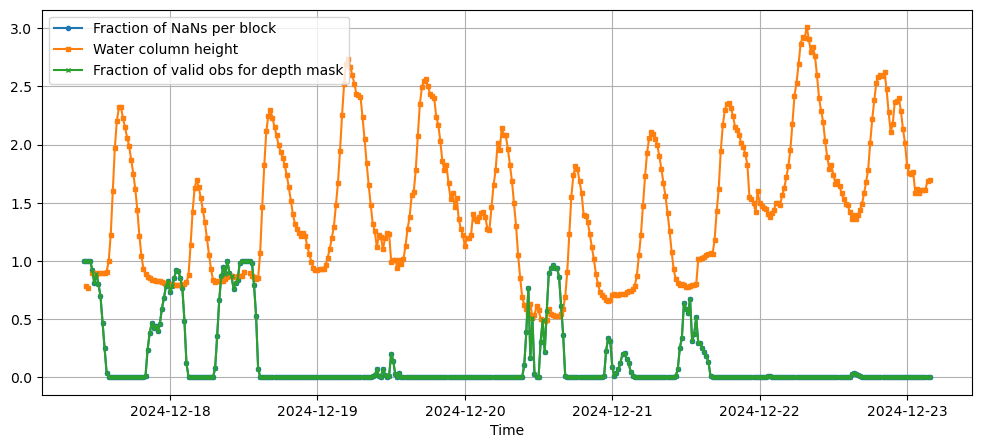

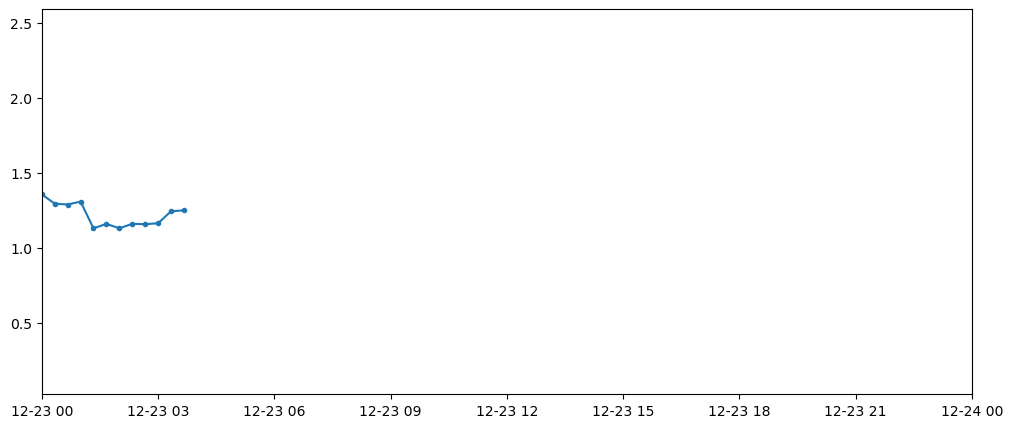

In [61]:
N_nans = ds.eta.isnull().sum(dim='N')/9573
#N_nans = N_nans.where(N_nans >= 1, 0) # make N_nans binary: 0 where <1
dh = ds['eta'] - zi_p_2D

plt.figure(figsize=(12, 5))
plt.plot(ds.t.values, N_nans, 'o-', markersize=3, label='Fraction of NaNs per block')
plt.plot(ds.t.values, ds.h.values, 's-', markersize=3,label='Water column height')
plt.plot(ds.t.values, 1-ds.maskd.sum(dim='N')/9573, 'x-', markersize=3,label='Fraction of valid obs for depth mask')
plt.xlabel('Time')
plt.grid()
plt.legend()

plt.figure(figsize=(12, 5))
plt.plot(ds.t.values, dh.mean(dim='N'), 'o-', markersize=3, label='Mean deviation of water level from sensor height')
#xlim only 23dec
plt.xlim(pd.to_datetime('2024-12-23'), pd.to_datetime('2024-12-24'))

In [62]:
# ROTATE VELOCITY TO ENU COORDINATES
# 'Interpolate' theta to t: use previous known value (so step-wise, not linear interpolation)
t_theta = pd.to_datetime(ds.t_theta.values)
theta = ds.theta_ADV.values

idx = np.searchsorted(t_theta, t_2D, side='right') - 1
idx = np.clip(idx, 0, len(theta) - 1)                            # Ensure indices are within bounds
theta_2D = theta[idx]

# rotate to ENU coordinates (this is only necessary if measurements were performed in XYZ
def rotate_velocities(u, v, thet):
    '''
    rotates vector (or array) [u,v] clockwise over angle thet (degrees)
    '''
    theta = thet / 180 * np.pi
    u_rot = u * np.cos(theta) + v * np.sin(theta)
    v_rot = -u * np.sin(theta) + v * np.cos(theta)
    return u_rot, v_rot

ufunc = lambda u,v,theta: rotate_velocities(u,v,theta-90)
ds['u'],ds['v'] = xr.apply_ufunc(ufunc,
                    ds['u'], ds['v'], theta_2D,
                    input_core_dims=[['N'], ['N'], ['N']],
                    output_core_dims=[['N'],['N']],
                    vectorize=True)

ds['u'].attrs = {'units':'m/s','long_name':'velocity E'}
ds['v'].attrs = {'units':'m/s','long_name':'velocity N'}
ds['w'].attrs = {'units':'m/s','long_name':'velocity U'}


In [63]:
# CONVERT THE OBS COUNT TO CONCENTRATION
# Count = (OBS-OBS_0) / A
OBS_0 = np.array([ [58.266, 30.649, 33.927, 77.137, 3465.4],
                   [59.014, 22.690, 31.018, 53.549, 3817.5] ])

A = np.array([     [78.072, 133.051, 81.026, 81.918, 2594.5],
                   [71.708, 56.307, 79.008, 71.579, 2337.3]    ])
n_clip = np.array([[65000, 65000, 65000, 65000, 64500],   # clipping value for high OBS
                   [65000, 65000, 65000, 65000, 65000]])  # clipping value for low OBS

# Add ds.C_OBShigh and ds.C_OBSlow, from ds.anl1 and ds.anl2
ds['C_OBShigh'] = (ds.anl1 - OBS_0[0,n_file]) / A[0,n_file]  # OBS count to concentration, for high OBS
ds['C_OBSlow']  = (ds.anl2 - OBS_0[1,n_file]) / A[1,n_file]  # OBS count to concentration, for low OBS

# replace concentrations < 0 by 0
ds['C_OBShigh'] = ds['C_OBShigh'].where(ds['C_OBShigh'] > 0, 0)
ds['C_OBSlow']  = ds['C_OBSlow'].where(ds['C_OBSlow'] > 0, 0)

# add metadata
ds['C_OBShigh'].attrs = {'units': 'g/L', 'long_name': 'concentration', 'comments': 'See clipping mask (mask_OBShigh) for which values are clipped'}
ds['C_OBSlow'].attrs = {'units': 'g/L', 'long_name': 'concentration', 'comments': 'See clipping mask (mask_OBSlow) for which values are clipped'}

# Add clipping mask for OBS concentration
ds.coords['mask_OBShigh'] = (('t', 'N'), ds.anl1.values < n_clip[0,n_file]) # true if valid data
ds.coords['mask_OBSlow']  = (('t', 'N'), ds.anl2.values < n_clip[1,n_file]) # true if valid data
ds['mask_OBShigh'].attrs = {'long_name': 'Clipping mask OBShigh', 'comments': 'True where data is valid. False where data is (nearly) clipped, i.e. count > ~65000. NB: mask is not applied yet, all concentrations are retained'}
ds['mask_OBSlow'].attrs =  {'long_name': 'Clipping mask OBSlow',  'comments': 'True where data is valid. False where data is (nearly) clipped, i.e. count > ~65000. NB: mask is not applied yet, all concentrations are retained'}

In [64]:
# QUALITY CONTROL: APPLY ALL MASKS
# Apply masks: remove velocity, pressure, water head, OBS count where masks are False
ds[['u','v','w','p','pc','eta','C_OBShigh','C_OBSlow']] = ds[['u','v','w','p','pc','eta','C_OBShigh','C_OBSlow']].where(ds.maskp == True)
ds[['u','v','w','p','pc','eta','C_OBShigh','C_OBSlow']] = ds[['u','v','w','p','pc','eta','C_OBShigh','C_OBSlow']].where(ds.maskv == True)
ds[['u','v','w','p','pc','eta','C_OBShigh','C_OBSlow']] = ds[['u','v','w','p','pc','eta','C_OBShigh','C_OBSlow']].where(ds.maskd == True)

# ammending the meta data to add extra info
ds.attrs['version'] = 'v2'
ds.attrs['coordinate type'] = 'ENU'
ds.attrs['comment'] = 'Quality checked data: pressure level corrected for atmospheric pressure,' + \
                 r'correlation and amplitude checks performed and spikes were removed. ' + \
                 r'Velocities rotated to ENU coordinates based on heading and configuration in the field.'

# save to netCDF wwhere we don't include the sen data any more because we have only used it for the quality check
ds = ds.drop_vars(['a1', 'a2', 'a3',
                   'cor1', 'cor2', 'cor3',
                   'snr1', 'snr2', 'snr3',
                   'heading', 'pitch', 'roll',
                   'voltage', 'p',
                   'anl1', 'anl2' ])

In [65]:
# SAVE THE DATASET TO NETCDF --------------------------------------------------------
# For compression, define a custom encoding dictionary for the ADV variables, to save variables with the orignial or necessary accuracy 
encoding = {'pc': { 'scale_factor': 1.0, 'dtype': 'int32', '_FillValue': -99999},  # max int16 is 32767, so 3.3 m water depth. Use int32 to be sure
            'u': { 'scale_factor': 0.001, 'dtype': 'int16', '_FillValue': -9999, 'shuffle': False},  # three decimals originally, so scale factor 0.001. max value is 7m/s, with 3 decimals is 7000 options, so int16 scale of ± 32767 is sufficient
            'v': { 'scale_factor': 0.001, 'dtype': 'int16', '_FillValue': -9999, 'shuffle': False},  # shuffle: flag for bit order. I just tried for which variables it saves data. (default flag is True when using deflate compression)
            'w': { 'scale_factor': 0.001, 'dtype': 'int16', '_FillValue': -9999, 'shuffle': False},
            'burst': { 'scale_factor': 1.0, 'dtype': 'int16', '_FillValue': -9999},
            'eta': { 'scale_factor': 0.001, 'dtype': 'int16', '_FillValue': -9999, 'shuffle': False},  # 3 decimals (mm precision), so scale factor 0.001
            'C_OBShigh': { 'scale_factor': 0.02, 'dtype': 'uint16', '_FillValue': 65535},
            'C_OBSlow':  { 'scale_factor': 0.02, 'dtype': 'uint16', '_FillValue': 65535} }

# Then extend the dictionary: add deflate compression level 4 to all variables and coordinates in netCDF, without overwriting existing keys
compression = {var: {"zlib": True, "complevel": 4} for var in list(ds.data_vars) + list(ds.coords)}  # temporary dict, with only compression settings
for var, comp in compression.items():  # for each variable in the dataset, 
    if var in encoding:                # if the variable already has an encoding, update it with the compression settings
        encoding[var].update(comp)
    else:                              # if the variable does not have an encoding yet, add it 
        encoding[var] = comp
ds.encoding = encoding  # add the encoding to the dataset (not really necessary, but allows retrieval later on)

ds.to_netcdf(map_file_out, encoding = ds.encoding)

In [66]:
#ds.pc.plot()

In [67]:
#ds.u.plot()